In [1]:
import glob
import pyarrow.parquet as pq
import pickle

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np


import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import transform
import shapely.wkt

from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt

import h3
import keplergl


ModuleNotFoundError: No module named 'pyarrow'

### Parking Transaction Data Column Descriptions

Meter_event_type: Event type of the meter, one of the following: NS = New Session; AT = Addtional Time; SC = Status Change

In [3]:
example_files= glob.glob('session_data/session_start_dt=2020-07-01/*')

In [4]:
example_format = pq.ParquetDataset(example_files).read_pandas().to_pandas()
example_format.head()

post_id                street_block payment_type    session_start_ts  \
0  658-02530                SPEAR ST 200         CASH 2020-07-01 13:47:03   
1  700-05390             VALENCIA ST 500         CASH 2020-07-01 13:47:07   
2  577-06040  MISSION BAY BLVD NORTH 600         CASH 2020-07-01 13:47:03   
3  472-00090                   HYDE ST 0         CASH 2020-07-01 13:47:22   
4  691-15420               UNION ST 1500  CREDIT CARD 2020-07-01 13:47:37   

       session_end_ts meter_event_type  gross_paid_amt  
0 2020-07-01 14:23:03               NS            0.30  
1 2020-07-01 14:29:07               NS            0.35  
2 2020-07-01 14:29:03               NS            0.35  
3 2020-07-01 14:51:15               NS            0.25  
4 2020-07-01 14:17:37               NS            0.25

### Meter_Map  Column Descriptions

Status of meter- M: Active, T: Temporarily inactive
For active meters only, filter for "ACTIVE_METER_FLAG" = "M" or "T". 

Meter_Type - How many spaces the meter manages-SS: Single‐space, MS: Multi‐space

Cap color describes the use and restrictions of the meter
- Black - Motorcycle parking 
- Brown - Tour bus parking 
- Green - Short term parking 
- Grey - General metered parking 
- Purple - Boat trailer parking, 
- Red - Six wheeled commercial vehicle parking
- Yellow - Commercial vehicle parking

In [5]:
def parquet_to_pandas(path, start_date, end_date):
    
    """ DON'T PUT TOO WIDE DURATION. WILL STOP THE KERNEL and RESULT MemoryError
        ex) DON'T read_parquet_folders(path, '2018-11-01', '2020-09-30')
        
        Drop rows where gross_paid_amt = 0
        
        Input - path (str) - Where SNAPPY compressed Parquet files located
                start_date (str) "YYYY-MM-DD" 
                end_date (str)   "YYYY-MM-DD"  
                
        Output - pd.DataFrame for Parquet files for given time range.
                
    """
    
    # Determine Date Interval
    dt_start_date = datetime.strptime(start_date, '%Y-%m-%d')
    dt_end_date = datetime.strptime(end_date, '%Y-%m-%d')
    delta_days_range = dt_end_date  - dt_start_date
    days_range = delta_days_range.days + 1
    date_list = [(dt_start_date + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(days_range)]
    
    df_list = []
    
    for date in date_list:
        # Grabbing all data Parquet files in each folder
        
        files = glob.glob(path+date+'/*')
        data = pq.ParquetDataset(files).read_pandas().to_pandas()
        data = data.drop_duplicates()
        df_list.append(data)
    
    
    concated_df = pd.concat(df_list)
    
    return concated_df

def binning_coordinate(list_coord, n=10):
    
    """
    Grouping coordinate (latitude or longitude), given list of coordinates
            
    Input - list_coord (list) - list of longitudes or latitudes
            n (int) - num of bins
    
    Output - grouping lambda function
    
    """
    n = n-1
    max_coord = max(list_coord)
    min_coord = min(list_coord)
    
    step = round((max_coord - min_coord) / n, 4)
    groups = lambda x: round(np.floor(x/step) * step, 4)
    
    return  groups


def roundStartTime(dt, minutes=15):
    
    """ 
        Round off given timestamp to given minute interval.
        
        Input - dt (datetime)
                minutes (int)
                
        Output - dt (datetime)
    """
    dt_minutes = dt.minute % 15
    dt_sec = dt.second
    
    return dt - timedelta(minutes=dt_minutes, seconds=dt_sec)

def roundEndTime(dt, minutes=15):
    """ 
        Round up given timestamp to given minute interval.
        
        Input - dt (datetime)
                minutes (int)
                
        Output - dt (datetime)
        
    """
    dt_minutes = 15 - (dt.minute % 15) - 1
    dt_sec = 60 - dt.second
    
    return dt + timedelta(minutes=dt_minutes, seconds=dt_sec)

def get_all_hex_id(gpd, res):
    """
        Get all unique h3 hex_id for SF
        
        Input - gpd  (Dataframe) Dataframe containing geojson information
                res (int) resolution
        Output - list of h3 hex_id covering all of Chicago
    """
    
    all_hex_id = []
    
    for i in range(len(gpd)):
        set_hexagons = h3.polyfill(geojson=gpd['geom_swap_geojson'][i], res=res)
        list_hex = list(set_hexagons)
        all_hex_id.append(list_hex)
    
    all_hex_id = sum(all_hex_id, [])
    
    return all_hex_id


### Preprocessing Data

In [41]:
# # Parking Session Data
# path = "session_data/session_start_dt="
# start_date = '2020-07-01'
# end_date = '2020-09-30'

# # Mainpulating start time and end time session into 15 minutes frame
# sf_parking = parquet_to_pandas(path, start_date, end_date)
# sf_parking['start_timeframe'] = sf_parking['session_start_ts'].apply(lambda x: roundStartTime(x))
# sf_parking['end_timeframe'] = sf_parking['session_end_ts'].apply(lambda x: roundEndTime(x))

# # Loading Parking Meter Data
# cols_interested =["POST_ID", "ACTIVE_METER_FLAG", "ON_OFFSTREET_TYPE", "METER_TYPE", "CAP_COLOR", "LATITUDE", "LONGITUDE"]
# meter_map = pd.read_csv("geodata/Parking_Meters.csv", usecols=cols_interested)

# # Only Consider Active Parking Meter
# active_meter_map = meter_map[meter_map['ACTIVE_METER_FLAG'].isin(["M","T"])]

# Square Grid (40 x 40) by grouping Latitude and Longitude
to_lat_bin = binning_coordinate(active_meter_map['LATITUDE'], n=40)
to_lon_bin = binning_coordinate(active_meter_map['LONGITUDE'], n=40)

active_meter_map['Lat_Bin'] = active_meter_map['LATITUDE'].map(to_lat_bin)
active_meter_map['Long_Bin'] = active_meter_map['LONGITUDE'].map(to_lon_bin)
active_meter_map['square_id'] = list(zip(active_meter_map['Lat_Bin'], active_meter_map['Long_Bin']))

# Hexagonal grid
active_meter_map['hex_id'] = active_meter_map.apply(lambda x: h3.geo_to_h3(x['LATITUDE'], x['LONGITUDE'], resolution=9), axis=1)

# Num_meters by grid
df_meter_by_square = active_meter_map.groupby(['Lat_Bin', 'Long_Bin'])['POST_ID'].nunique().reset_index()
df_meter_by_square.rename(columns={"POST_ID": "Num_Meters"}, inplace=True)
df_meter_by_square['square_id'] = list(zip(df_meter_by_square['Lat_Bin'], df_meter_by_square['Long_Bin']))

df_meter_by_hex = active_meter_map.groupby('hex_id')['POST_ID'].nunique().reset_index()
df_meter_by_hex.rename(columns={'POST_ID': 'Num_Meters'}, inplace=True)

# Based on grid_id, total available number of meters. {id : total_meters}
num_meter_by_square = df_meter_by_square[['square_id', 'Num_Meters']].to_dict()
num_meter_by_hex = active_meter_map.groupby('hex_id')['POST_ID'].nunique().to_dict()

# Geojson_data
sf_neighborhoods = gpd.read_file('geodata/SF Find Neighborhoods.geojson', driver='GeoJSON')

# Changing the order of coordinates from Longitude and Latitude to Latitude and Longitude
not_include = ['Treasure Island', 'Yerba Buena Island']
sf_neighborhoods = sf_neighborhoods[sf_neighborhoods['name'] != 'Treasure Island'].reset_index()
sf_neighborhoods['swap_geometry'] = sf_neighborhoods['geometry'].apply(lambda x: [shapely.wkt.loads(transform(lambda lon,lat: (lat,lon), x[0]).wkt)])
sf_neighborhoods['geom_swap_geojson'] = sf_neighborhoods['swap_geometry'].apply(lambda x: gpd.GeoSeries(x).__geo_interface__['features'][0]['geometry'])

# Getting all hexagons in sf with resolution 9 and record no-parking meters hex_id with 0. 
all_sf_hex = get_all_hex_id(sf_neighborhoods, 9)

no_parking_h3 = set(all_sf_hex).difference(set(num_meter_by_hex.keys()))
no_parking_df = pd.DataFrame.from_dict(dict(zip(no_parking_h3, np.zeros(len(no_parking_h3)))).items())
no_parking_df.rename(columns={0: 'hex_id', 1: 'Num_Meters'}, inplace=True)

all_sf_meter_h3 = pd.concat([df_meter_by_hex, no_parking_df])

sf_data = sf_parking.merge(active_meter_map[['POST_ID', 'square_id', 'hex_id']], left_on='post_id', right_on='POST_ID')

In [42]:
unique_hex = list(set(sf_data['hex_id']))
unique_square = list(set(sf_data['square_id']))

print('There are {0} hex_ids containing parking meters while {1} square_ids'.format(len(unique_hex), len(unique_square)))

There are 309 hex_ids containing parking meters while 424 square_ids


In [32]:
all_sf_meter_h3.to_csv('res_9_total_parking.csv')

In [40]:
with open('num_meter_by_square.pickle', 'wb') as handle:
    pickle.dump(num_meter_by_square, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Calculating distance of Square

In [10]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [11]:
distance(37.8075, 37.8075, -122.5018, -122.4989)

0.25477168968006375

### Filling the number of Parking Occupancy in hex_ids based on Start and End Session

In [12]:
adjusted_end_date = datetime.fromisoformat(end_date)+timedelta(days=1)
str_adjusted_end_date = adjusted_end_date.strftime('%Y-%m-%d')
day_range = pd.date_range(start=start_date, end=str_adjusted_end_date, freq='15T')

In [13]:
def filling_parking(unique_id, sf_data, day_range):
    """
    
    Given DataFrame and unique location id,
    Calculate the total number of parking occupancy based on day_range
    
    Input - unique_id (list)
            sf_data (DataFrame)
            day_range (DatetimeIndex)
                
    Output - unique_id_dict (dict)
    
    """
    unique_id_dict = {}
    for u_id in unique_id:
        day_dict = dict(zip(day_range, np.zeros(len(day_range))))
        df_post_id = sf_data[sf_data['hex_id'] == h3]
        
        for start_time, end_time in zip(df_post_id['start_timeframe'], df_post_id['end_timeframe']):
            
            # Filter timeframes between session start time and session end time, 
            occupied_filter = (day_range >= start_time) & (day_range <= end_time)
            occupied_timeframe = day_range[occupied_filter]

            for timeframe in occupied_timeframe:
                day_dict[timeframe] =  day_dict.get(timeframe,0) + 1

        unique_id_dict[u_id] = pd.Series(day_dict)
    return unique_id_dict


def fill_h3_ids(pivoted_df, all_hex_id):
    
    for hex_id in all_hex_id:
        if hex_id not in pivoted_df.columns:
            pivoted_df[hex_id] = 0.0
    

In [14]:
hex_id_dict = filling_parking(unique_hex, sf_data, day_range)
square_id_dict = filling_parking(unique_square, sf_data, day_range)

# with open('hex_dict_2020_q3_res9.pickle', 'wb') as handle:
#     pickle.dump(hex_id_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('smaller_square_dict_2020_q3.pickle', 'wb') as handle:
#     pickle.dump(square_id_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
with open(r"hex_dict_2020_q3_res9.pickle", "rb") as input_file:
    hex_id_dict = pickle.load(input_file)

with open(r"smaller_square_dict_2020_q3.pickle", "rb") as input_file:
    square_id_dict = pickle.load(input_file)

In [48]:
pivoted_hex_id = pd.DataFrame(hex_id_dict)
pivoted_square_id = pd.DataFrame(square_id_dict)

In [17]:
fill_h3_ids(pivoted_hex_id, all_sf_hex)
print("SF Data was filled with {} hexagons with no-parking meters ".format(len(all_sf_hex) - len(set(active_meter_map['hex_id']))))

SF Data was filled with 790 hexagons with no-parking meters 


### Manipulate Date to feed into CNN

In [18]:
before_train_h3 = pivoted_hex_id.reset_index().melt('index').sort_values('index').reset_index(drop=True)
before_train_h3.rename(columns={'index': 'timestamp', 'variable': 'hex_id', 'value': 'parking_occupancy'}, inplace=True)
before_train_h3 = before_train_h3[before_train_h3['timestamp'] != '2020-10-01']

# (Num of parking vacacny / Num of total available pakring)
before_train_h3['total_parking_available'] = before_train_h3['hex_id'].map(num_meter_by_hex).fillna(0)
before_train_h3['parking_occupancy_rate'] = before_train_h3[['parking_occupancy', 'total_parking_available']].apply(lambda x: 0 if x[1] == 0 else x[0]/x[1], axis=1)

In [21]:
before_train_h3[before_train_h3.timestamp == '2020-07-01 00:00:00'].to_csv('before_train_h3.csv')

In [49]:
before_train_square = pivoted_square_id.reset_index().melt('index').sort_values('index').reset_index(drop=True)
before_train_square.rename(columns={'index': 'timestamp', 'variable_0': 'Lat_Bin', 'variable_1':'Long_Bin', 'value': 'parking_occupancy'}, inplace=True)
before_train_square['square_id'] = list(zip(before_train_square['Lat_Bin'], before_train_square['Long_Bin']))
# Excluding 2020-08-01. Only considering July 2020
before_train_square = before_train_square[before_train_square['timestamp'] != '2020-10-01']

before_train_square['total_parking_available'] = before_train_square['square_id'].map(num_meter_by_square).fillna(0)
before_train_square['parking_occupancy_rate'] = before_train_square[['parking_occupancy', 'total_parking_available']].apply(lambda x: 0 if x[1] == 0 else x[0]/x[1], axis=1)

In [23]:
before_train_square.to_csv("before_train_square.csv")

In [52]:
split_timeframe = '2020-09-07 00:00:00'

df_train_h3 = before_train_h3[before_train_h3['timestamp'] < split_timeframe]
df_test_h3 = before_train_h3[before_train_h3['timestamp'] >= split_timeframe]

df_train_square = before_train_square[before_train_square['timestamp'] < split_timeframe]
df_test_square = before_train_square[before_train_square['timestamp'] >= split_timeframe]

In [188]:
def h3_df_to_matrix(df, valuename="parking_occupancy"):
    """
        Given a DataFrame containing timestamp, hex_id and pickup value, convert to matrix/ 2d array
        
    """
    dict_ij = {} # location i,j
    dict_values = {} # Pick up values
    
    local_origin = df.iloc[0]['hex_id']
    for i, row in df.iterrows():
        ij_ex = h3.experimental_h3_to_local_ij(origin = local_origin,
                                               h = row["hex_id"])
        dict_ij[row["hex_id"]] = ij_ex
        dict_values[row["hex_id"]] = row[valuename]

    # post-process
    min_i = min([dict_ij[h][0] for h in dict_ij])
    min_j = min([dict_ij[h][1] for h in dict_ij])

    max_i = max([dict_ij[h][0] for h in dict_ij])
    max_j = max([dict_ij[h][1] for h in dict_ij])

    # rescale
    dict_ij_rescaled = {}
    for h in dict_ij:
        dict_ij_rescaled[h] = [dict_ij[h][0] - min_i, dict_ij[h][1] - min_j]

    num_rows = max_i - min_i + 1
    num_cols = max_j - min_j + 1

    arr_ij = np.zeros(shape=(num_rows, num_cols), dtype = np.float32)## Subtract -5 to easily visualize chicago map
    
    for h in dict_ij_rescaled:
        arr_ij[dict_ij_rescaled[h][0]][dict_ij_rescaled[h][1]] = dict_values[h]
    #arr_ij = np.rot90(arr_ij,2)
    return arr_ij
    

In [189]:
july_first_h3 = df_train_h3[df_train_h3.timestamp == '2020-07-01 15:00:00']

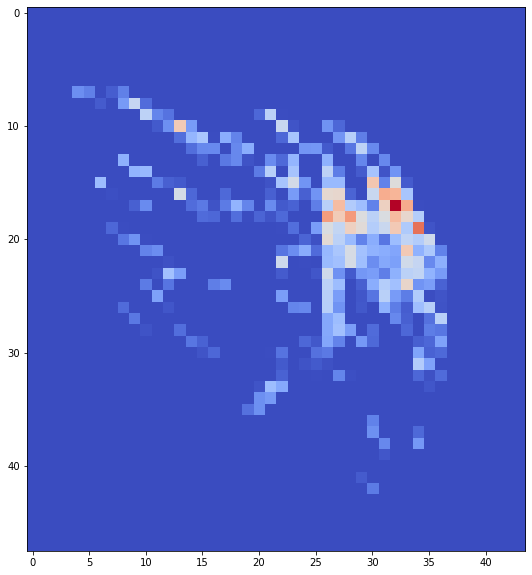

In [190]:
# Parking Meter Distribution in H3 (48,44)
plt.figure(figsize = (10,10))
plt.imshow(h3_df_to_matrix(july_first_h3, 'total_parking_available'), cmap='coolwarm')
plt.show()

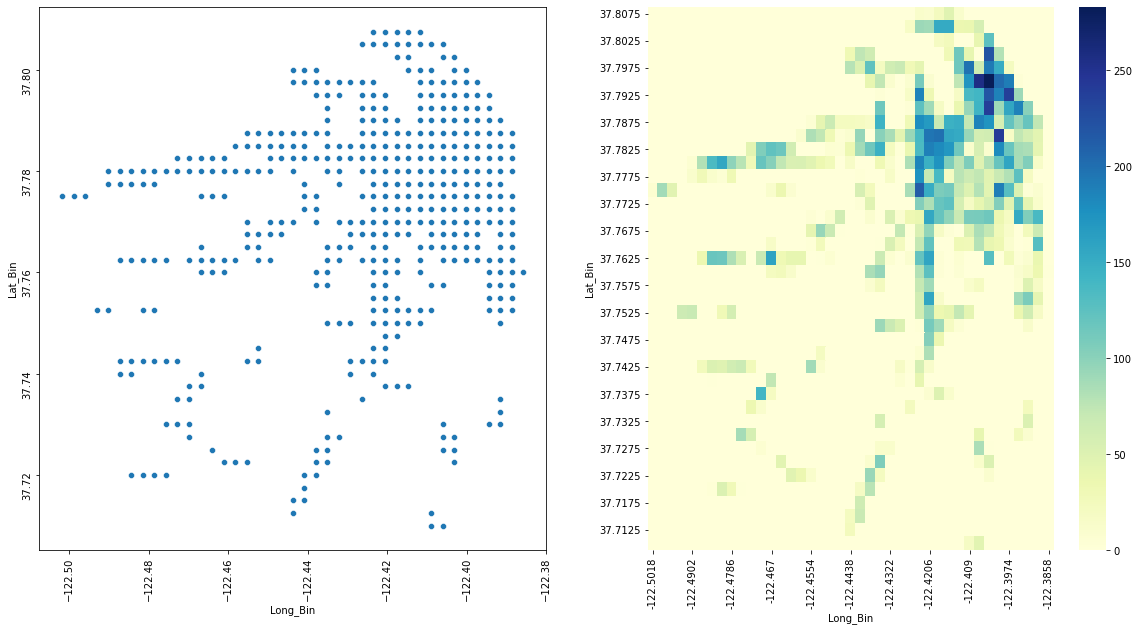

In [191]:
# Pivoting num_meter_by_square to plot parking meter distribution
s_sf = df_meter_by_square.pivot(index='Lat_Bin', columns='Long_Bin', values='Num_Meters').fillna(0)
# Reversing Latitude
s_sf = s_sf[::-1]

# Each Point represents a square with ~ width: .28 km, height: .25 km
fig, axes = plt.subplots(figsize=(20,10), nrows=1, ncols=2)

meter_loc = sns.scatterplot(x='Long_Bin', y='Lat_Bin', data=df_meter_by_square, ax=axes[0])
meter_loc.tick_params(labelrotation=90)

meter_dist = sns.heatmap(s_sf, cmap='YlGnBu', ax=axes[1])
meter_dist.set_xticks(meter_dist.get_xticks()[::2])
meter_dist.set_yticks(meter_dist.get_yticks()[::2])

plt.show()

In [50]:
def h3_split_sequence(melted_df, shape_size=(48,44,1), lag=8):
    """
        Split the dataframe to timeseries data

    """
    chunk_15_min = melted_df.hex_id.nunique()
    num_row = int(len(melted_df)/chunk_15_min)
    data_x, data_y = [], []
    for i in range(lag,num_row):
        y = np.array(h3_df_to_matrix(melted_df[i*chunk_15_min:(i+1)*chunk_15_min])).reshape(shape_size)
        data_y.append(y)
        x = []
        for j in reversed(range(lag)):
            j = i-j
            x_15 = h3_df_to_matrix(melted_df[((j-1)*chunk_15_min):j*chunk_15_min])
            x.append(np.array(x_15))
        data_x.append(np.array(x).transpose([1,2,0]))
    return np.array(data_x), np.array(data_y)

def square_split_sequence(melted_df, shape_size=(40,40,1), lag=8):
    """
        Split the dataframe to timeseries data

    """
    
    chunk_15_min = melted_df.square_id.nunique()
    num_row = int(len(melted_df)/chunk_15_min)
    data_x, data_y = [], []
    for i in range(lag,num_row):
        y_values = melted_df[i*chunk_15_min:(i+1)*chunk_15_min].pivot(index='Lat_Bin', columns='Long_Bin', values=['parking_occupancy']).fillna(0).values
        y = np.array(y_values).reshape(shape_size)
        data_y.append(y)
        x = []
        for j in reversed(range(lag)):
            j = i-j
            x_15 = melted_df[((j-1)*chunk_15_min):j*chunk_15_min].pivot(index='Lat_Bin', columns='Long_Bin', values=['parking_occupancy']).fillna(0).values
            x.append(np.array(x_15))
        data_x.append(np.array(x).transpose([1,2,0]))
    return np.array(data_x), np.array(data_y)
    

In [54]:
train_h3_x, train_h3_y = h3_split_sequence(df_train_h3)
test_h3_x, test_h3_y = h3_split_sequence(df_test_h3)

# np.savez('h3_train_x_2020q3_res9.npz', train_h3_x)
# np.savez('h3_train_y_2020q3_res9.npz', train_h3_y)
# np.savez('h3_test_x_2020q3_res9.npz', test_h3_x)
# np.savez('h3_test_y_2020q3_res9.npz', test_h3_y)

train_square_x, train_square_y = square_split_sequence(df_train_square)
test_square_x, test_square_y = square_split_sequence(df_test_square)

# np.savez('smaller_square_train_x.npz', train_square_x)
# np.savez('smaller_square_train_y.npz', train_square_y)
# np.savez('smaller_square_test_x.npz', test_square_x)
# np.savez('smaller_square_test_y.npz', test_square_y)

In [195]:
# train_h3_x = np.load('h3_train_x_2020q3_res9.npz')['arr_0']
# train_h3_y = np.load('h3_train_y_2020q3_res9.npz')['arr_0']
# test_h3_x = np.load('h3_test_x_2020q3_res9.npz')['arr_0']
# test_h3_y = np.load('h3_test_y_2020q3_res9.npz')['arr_0']

# train_square_x = np.load('smaller_square_train_x.npz')['arr_0']
# train_square_y = np.load('smaller_square_train_y.npz')['arr_0']
# test_square_x = np.load('smaller_square_test_x.npz')['arr_0']
# test_square_y = np.load('smaller_square_test_y.npz')['arr_0']

In [193]:
assert sum(train_h3_y[0].flatten() == train_h3_x[8][:,:,0].flatten()) == (train_h3_x.shape[1] * train_h3_x.shape[2])

In [196]:
assert sum(train_square_y[32].flatten() == train_square_x[40][:,:,0].flatten()) == (train_square_x.shape[1] * train_square_x.shape[2])